<a href="https://colab.research.google.com/github/BDouchet/SDATA/blob/main/TP_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and load dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import seaborn as sns

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1FIIo3FFl9VTavlLfk1c_OAyF00eOZ336'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('iris.csv')

# Read dataset into a dataframe

In [2]:
df=pd.read_csv('iris.csv')
print(df.dtypes)
df

sepal.length    float64
sepal.width     float64
petal.length    float64
petal.width     float64
variety          object
dtype: object


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


# Data Visualization

In [3]:
df.describe()

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


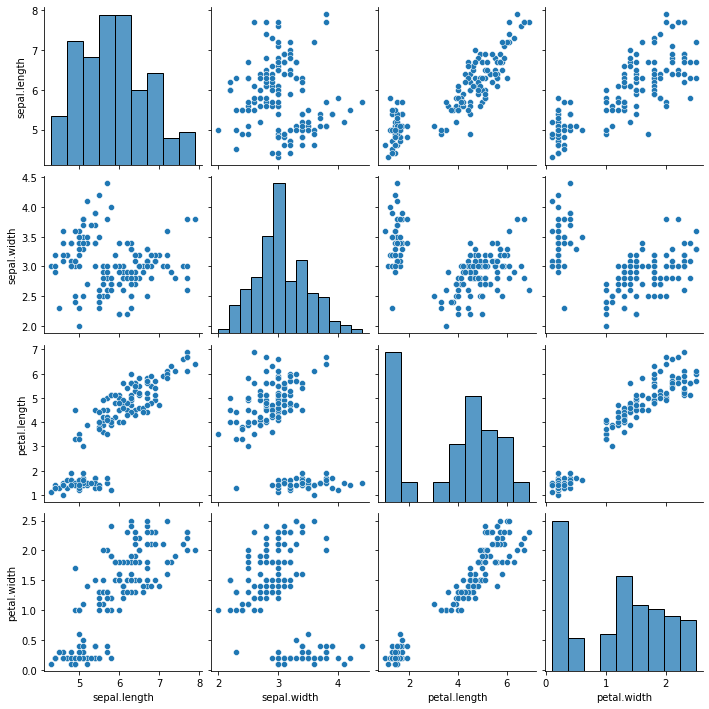

In [4]:
sns.pairplot(df)

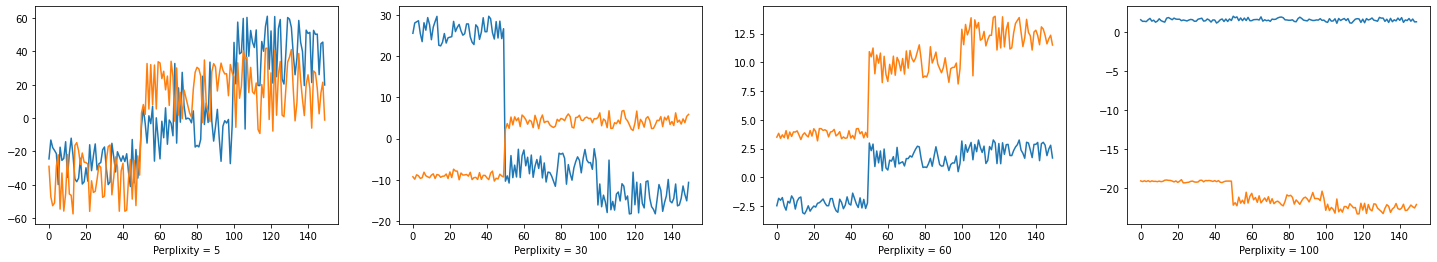

In [5]:
from sklearn.manifold import TSNE

perplexities=[5,30,60,100]

_,axs=plt.subplots(ncols=4,nrows=1,figsize=(25,4))
for i,ax in enumerate(axs.flatten()):
    plt.sca(ax)
    df_embed=TSNE(perplexity=perplexities[i]).fit_transform(df[df.columns[:-1]])
    ax.plot(df_embed)
    ax.set_xlabel('Perplixity = '+str(perplexities[i]))

# Preprocessing

In [6]:
X=df[df.columns[:-1]].to_numpy()
Y=df['variety'].to_numpy()

print(X.shape,Y.shape)

(150, 4) (150,)


In [7]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
Y_lab=le.fit_transform(Y)
print(le.classes_)
unique, counts = np.unique(Y_lab, return_counts=True)
dict(zip(unique, counts))

['Setosa' 'Versicolor' 'Virginica']


{0: 50, 1: 50, 2: 50}

# Manual LDA

In [8]:
m0,m1,m2=X[:50].mean(axis=0),X[50:100].mean(axis=0),X[100:].mean(axis=0)
m=X.mean(axis=0)

sub0,sub1,sub2=np.array([X[i]-m0 for i in range(50)]),np.array([X[i]-m1 for i in range(50,100)]),np.array([X[i]-m2 for i in range(100,150)])

s0,s1,s2=np.sum([np.outer(sub,sub.T) for sub in sub0],axis=0),np.sum([np.outer(sub,sub.T) for sub in sub1],axis=0),np.sum([np.outer(sub,sub.T) for sub in sub2],axis=0)

swin=np.sum([s0,s1,s2],axis=0)
swin

array([[38.9562, 13.63  , 24.6246,  5.645 ],
       [13.63  , 16.962 ,  8.1208,  4.8084],
       [24.6246,  8.1208, 27.2226,  6.2718],
       [ 5.645 ,  4.8084,  6.2718,  6.1566]])

In [9]:
mis=[m0,m1,m2]
swbt=np.sum([50*np.outer(mi-m,mi-m) for mi in mis],axis=0)
swbt

array([[ 63.21213333, -19.95266667, 165.2484    ,  71.27933333],
       [-19.95266667,  11.34493333, -57.2396    , -22.93266667],
       [165.2484    , -57.2396    , 437.1028    , 186.774     ],
       [ 71.27933333, -22.93266667, 186.774     ,  80.41333333]])

In [10]:
prod=np.linalg.inv(swin) @ swbt
print(prod)
print()

eigen_values,eigen_vectors=np.linalg.eig(prod)

pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])
print()

eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

[[ -3.05836939   1.08138264  -8.1119227   -3.45864987]
 [ -5.56163926   2.17821866 -14.96461194  -6.30773951]
 [  8.07743878  -2.94271854  21.5115909    9.14206468]
 [ 10.49708187  -3.41985449  27.54852482  11.84588007]]

32.191929198278025
0.28539104262306675
4.959432720746535e-15
8.530239058578782e-16

Explained Variance
Eigenvector 0: 0.9912126049653671
Eigenvector 1: 0.008787395034632587
Eigenvector 2: 1.5270449298032764e-16
Eigenvector 3: 2.6265218297893983e-17


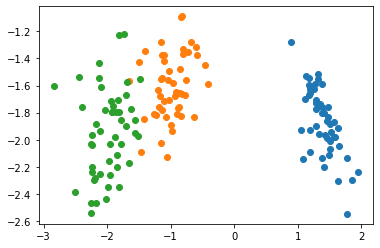

In [11]:
w_matrix = np.hstack((pairs[0][1].reshape(4,1), pairs[1][1].reshape(4,1))).real

X_trans=X @ w_matrix
plt.scatter(X_trans[:50,0],X_trans[:50,1])
plt.scatter(X_trans[50:100,0],X_trans[50:100,1])
plt.scatter(X_trans[100:,0],X_trans[100:,1])
plt.show()

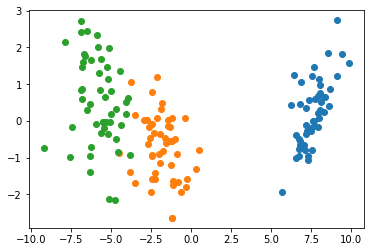

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda=LinearDiscriminantAnalysis(n_components=2)
X_trans=lda.fit_transform(X,Y_lab)
plt.scatter(X_trans[:50,0],X_trans[:50,1])
plt.scatter(X_trans[50:100,0],X_trans[50:100,1])
plt.scatter(X_trans[100:,0],X_trans[100:,1])
plt.show()

In [13]:
import math

def predict(x):
    cks=[]
    cov0,cov1,cov2=np.cov(X[:50].T),np.cov(X[50:100].T),np.cov(X[100:].T)
    cov=np.sum([cov0,cov1,cov2],axis=0)/3
    for i in range(3):
        mi=mis[i]
        ck=x @ np.linalg.inv(cov) @ mi[:,np.newaxis] - 0.5 * mi @ np.linalg.inv(cov) @ mi[:,np.newaxis]
        cks.append(ck+np.argmax(math.log(1/3)))
    ind=np.argmax(np.array(cks))
    return ind,le.classes_[ind]

print(predict(X[10]))
print(predict(X[60]))
print(predict(X[100]))

(0, 'Setosa')
(1, 'Versicolor')
(2, 'Virginica')


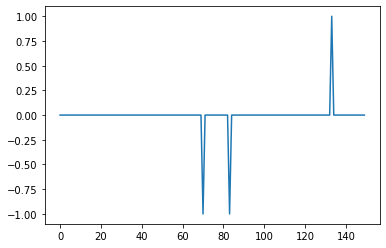

In [14]:
yhat=[predict(x)[0] for x in X]
plt.plot(Y_lab-yhat)
plt.show()

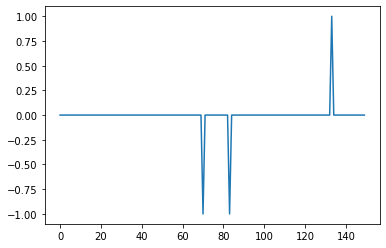

In [15]:
yhat=lda.predict(X)
plt.plot(Y_lab-yhat)
plt.show()

#Train_test_split vs K-fold

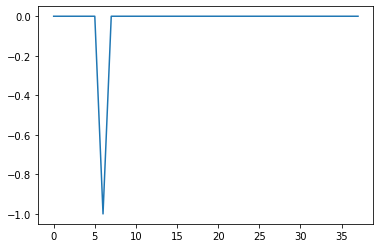

0.9754062362758015


array([[10,  0,  0],
       [ 0, 11,  1],
       [ 0,  0, 16]])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix

X_train,X_test,Y_train,Y_test=train_test_split(X,Y_lab,test_size=0.25)
lda=LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train,Y_train)
Yhat_test=lda.predict(X_test)

plt.plot(Y_test-Yhat_test)
plt.show()

print(f1_score(Y_test,Yhat_test,average='macro'))

confusion_matrix(Y_test,Yhat_test)

In [17]:
from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(shuffle=True)
skf.get_n_splits(X,Y_lab)
f1=0
for i,(train_index, test_index) in enumerate(skf.split(X, Y_lab)):
    X_train,X_test=X[train_index],X[test_index]
    Y_train,Y_test=Y[train_index],Y[test_index]
    lda=LinearDiscriminantAnalysis(n_components=2)
    lda.fit(X_train,Y_train)
    Yhat_test=lda.predict(X_test)
    f1+=f1_score(Y_test,Yhat_test,average='macro')
print(f1/(i+1))

0.9799498746867169


# Draw decision boundaries

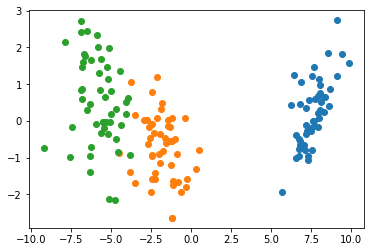

In [18]:
X_trans=lda.fit_transform(X,Y_lab)
plt.scatter(X_trans[:50,0],X_trans[:50,1])
plt.scatter(X_trans[50:100,0],X_trans[50:100,1])
plt.scatter(X_trans[100:,0],X_trans[100:,1])
dec=lda.decision_function(X)
plt.show()

In [52]:
xx,yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-3, 3, 200))
print(np.c_[xx.ravel(),yy.ravel()].shape)
Z=lda.predict_proba(np.c_[xx.ravel(),yy.ravel()])
Z.shape


(40000, 2)


ValueError: ignored

In [30]:
grid = np.mgrid[3.5:8:500j,2:5:400j]
gridT = grid.reshape((2,-1)).T
grid.shape

(2, 500, 400)

In [36]:
plt.scatter(Z[:,0],Z[:,1])
plt.show()

IndexError: ignored